In [601]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.metrics import accuracy_score

# READ FROM DATABASE

In [602]:
import psycopg2

In [603]:
# jdbc:postgresql://pg-graduate-delt.postgres.database.azure.com:5432/{your_database}?user=snartimaal&password={your_password}&sslmode=require
with psycopg2.connect(
    database='pgsql-graduate-gruppe3',
    user='snartimaal',
    password='#st44p44nu',
    host='pg-graduate-delt.postgres.database.azure.com'
) as conn:
    cur = conn.cursor()

### Mattilsynet 

In [604]:
try:
    cur = conn.cursor()
    df_sql_mat = pd.read_sql_query("SELECT m.orgnummer, m.postnr, m.total_karakter, m.dato, m.tilsynsbesoektype, cs.antallansatte, cs.naeringskode1_kode \
                                  FROM mattilsynet m \
                                  JOIN orgnumber_junction oj ON m.orgnummer = oj.orgnumber \
                                  JOIN company_subunit cs ON oj.orgnumber = cs.organisasjonsnummer ;", 
                                  conn)
except:
    conn.rollback()
    cur.close()

C:\Users\STM\AppData\Local\Temp\ipykernel_3804\320550458.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql_mat = pd.read_sql_query("SELECT m.orgnummer, m.postnr, m.total_karakter, m.dato, m.tilsynsbesoektype, cs.antallansatte, cs.naeringskode1_kode \


### Google Review

In [522]:
try:
    cur = conn.cursor()
    df_sql_reviews = pd.read_sql("SELECT gr.organisasjonsnummer AS orgnummer, gr.individual_rating \
                                 FROM google_review gr;", 
                                 conn)
except:
    conn.rollback()
    cur.close()


C:\Users\STM\AppData\Local\Temp\ipykernel_3804\2155275846.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql_reviews = pd.read_sql("SELECT gr.organisasjonsnummer AS orgnummer, gr.individual_rating \


In [523]:
avg_df = df_sql_reviews.groupby('orgnummer').mean()
min_max_df = (df_sql_reviews.groupby('orgnummer').max()) - (df_sql_reviews.groupby('orgnummer').min())
min_max_df['dif_rating'] = min_max_df.pop('individual_rating')
avg_df['avg_rating'] = avg_df.pop('individual_rating')

In [524]:
min_max_df

,dif_rating
orgnummer,
811614742,3.0
812467832,1.0
812561952,4.0
812869922,4.0
812901842,2.0
...,...
999640516,4.0
999650236,0.0
999651380,2.0


In [531]:
df = pd.merge(df_sql_mat, avg_df, how='left', on='orgnummer')
df = pd.merge(df, min_max_df, how='left', on='orgnummer')

In [532]:
df

,orgnummer,postnr,total_karakter,dato,tilsynsbesoektype,antallansatte,naeringskode1_kode,avg_rating,dif_rating
0,915937144,368,2,21112022,1,69.0,56.101,4.4,2.0
1,974999439,366,0,23012020,0,17.0,47.241,4.0,2.0
2,915893848,369,0,14092017,1,25.0,56.101,4.6,1.0
3,919228660,178,0,21082018,1,7.0,56.101,4.8,1.0
4,912240770,1081,0,26112018,1,80.0,55.101,3.2,3.0
...,...,...,...,...,...,...,...,...,...
5836,915465870,194,0,19012023,1,34.0,56.101,NaN,NaN
5837,996480550,190,1,01092022,0,4.0,56.102,2.4,4.0
5838,913536835,194,0,09092022,0,4.0,56.101,5.0,0.0
5839,929774671,179,1,12122022,0,21.0,56.101,2.6,4.0


In [533]:
df.isnull().sum()

orgnummer               0
postnr                  0
total_karakter          0
dato                    0
tilsynsbesoektype       0
antallansatte           0
naeringskode1_kode      0
avg_rating            658
dif_rating            658
dtype: int64

In [546]:
df_copy = df.copy()

In [547]:
mean_avg = df_copy['avg_rating'].mean()
mean_avg

4.0969129847578625

In [551]:
df_copy['avg_rating'] = df_copy['avg_rating'].fillna(value=mean_avg)


In [552]:
mean_dif = df_copy['dif_rating'].mean()
df_copy['dif_rating'] = df_copy['dif_rating'].fillna(value=mean_dif)

In [553]:
df_copy

,orgnummer,postnr,total_karakter,dato,tilsynsbesoektype,antallansatte,naeringskode1_kode,avg_rating,dif_rating
0,915937144,368,2,21112022,1,69.0,56.101,4.400000,2.000000
1,974999439,366,0,23012020,0,17.0,47.241,4.000000,2.000000
2,915893848,369,0,14092017,1,25.0,56.101,4.600000,1.000000
3,919228660,178,0,21082018,1,7.0,56.101,4.800000,1.000000
4,912240770,1081,0,26112018,1,80.0,55.101,3.200000,3.000000
...,...,...,...,...,...,...,...,...,...
5836,915465870,194,0,19012023,1,34.0,56.101,4.096913,2.154158
5837,996480550,190,1,01092022,0,4.0,56.102,2.400000,4.000000
5838,913536835,194,0,09092022,0,4.0,56.101,5.000000,0.000000
5839,929774671,179,1,12122022,0,21.0,56.101,2.600000,4.000000


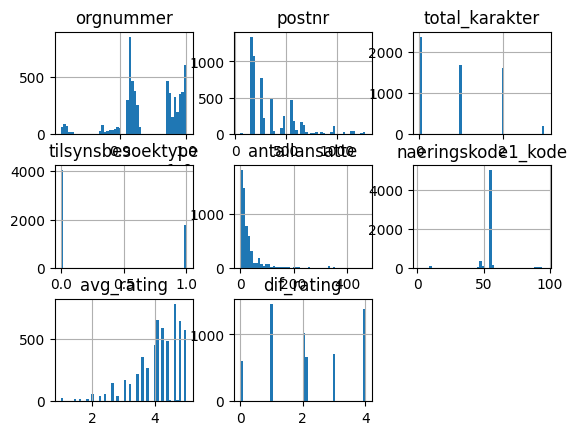

In [555]:
df_copy.hist(bins=50)
plt.show()

# DATA PREP

In [556]:
# Endre dato til kun år ? De 4 siste sifrene 
dato = df_copy['dato']
year_list = []

for i in dato.values:
    year_list.append(i[-4:])

df_copy['year'] = year_list

In [557]:
ss_features = ['postnr', 'orgnummer', 'tilsynsbesoektype', 'naeringskode1_kode', 'antallansatte', 'avg_rating', 'dif_rating']
ss_scaler = StandardScaler()
ss_scaler.fit(df_copy[ss_features])
transformed_ss = ss_scaler.transform(df_copy[ss_features])
df_copy[ss_features] = transformed_ss

In [558]:
df_copy

,orgnummer,postnr,total_karakter,dato,tilsynsbesoektype,antallansatte,naeringskode1_kode,avg_rating,dif_rating,year
0,-0.605357,0.009073,2,21112022,1.503764,0.897237,0.092761,0.407268,-0.117689,2022
1,0.667806,0.001201,0,23012020,-0.664998,-0.274427,-1.013360,-0.130225,-0.117689,2020
2,-0.606290,0.013008,0,14092017,1.503764,-0.094171,0.092761,0.676015,-0.881121,2017
3,-0.534404,-0.738743,0,21082018,1.503764,-0.499746,0.092761,0.944762,-0.881121,2018
4,-0.685037,2.815350,0,26112018,1.503764,1.145089,-0.032083,-1.205213,0.645743,2018
...,...,...,...,...,...,...,...,...,...,...
5836,-0.615516,-0.675769,0,19012023,1.503764,0.108617,0.092761,0.000000,0.000000,2023
5837,1.130859,-0.691513,1,01092022,-0.664998,-0.567342,0.092886,-2.280200,1.409174,2022
5838,-0.657099,-0.675769,0,09092022,-0.664998,-0.567342,0.092761,1.213509,-1.644552,2022
5839,-0.307071,-0.734807,1,12122022,-0.664998,-0.184299,0.092761,-2.011453,1.409174,2022


# TRAIN TEST SPLIT

###
features_test = df[['postnr', 'year', 'orgnummer', 'tilsynsbesoektype', 'naeringskode1_kode', 'antallansatte', 'avg_rating', 'dif_rating']]
X = np.c_[features_test]
y = np.c_[df['total_karakter']]

print(f'X len : {len(X)}')
print(f'y len : {len(y)}')

print(X.data.shape,
y.data.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
###

In [573]:
df_train = df_copy[df_copy['year'] < '2022']
df_test = df_copy[df_copy['year'] >= '2022']

In [580]:
X_train = np.c_[df_train[['postnr', 'year', 'orgnummer', 'tilsynsbesoektype', 'naeringskode1_kode', 'antallansatte', 'avg_rating', 'dif_rating']]]
y_train = np.c_[df_train['total_karakter']]

X_test = np.c_[df_test[['postnr', 'year', 'orgnummer', 'tilsynsbesoektype', 'naeringskode1_kode', 'antallansatte', 'avg_rating', 'dif_rating']]]
y_test = np.c_[df_test['total_karakter']]

In [581]:
print(f'X_train len : {len(X_train)}')
print(f'X_test len : {len(X_test)}')
print(f'y_train len : {len(y_train)}')
print(f'y_test len : {len(y_test)}')

X_train len : 4239
X_test len : 1602
y_train len : 4239
y_test len : 1602


In [582]:
print(X_train.shape, y_train.shape)

(4239, 8) (4239, 1)


# Naiv score

In [583]:
pred_naiv = np.mean(y_train)
y_pred_naiv = np.full(y_test.shape, pred_naiv)
print(f'y_pred_naiv : {y_pred_naiv}')

mse_naiv = mean_squared_error(y_test, y_pred_naiv)
print(f'Naiv MSE : {np.sqrt(mse_naiv)}') # 0.9006

mae_naiv = mean_absolute_error(y_test, y_pred_naiv)
print(f'Naiv MAE : {mae_naiv}') # 0.7660

y_pred_naiv : [[0.93866478]
 [0.93866478]
 [0.93866478]
 ...
 [0.93866478]
 [0.93866478]
 [0.93866478]]
Naiv MSE : 0.8449077795580826
Naiv MAE : 0.6735902191145239


# XGBoost Model

In [585]:
regressor = xgb.XGBRegressor(
    early_stopping_rounds = 20,
    max_depth = 5
)

regressor.fit(X_train, y_train, eval_set = [(X_test, y_test)])
importance_check = pd.DataFrame(regressor.feature_importances_.reshape(1,-1), columns = [['postnr', 'year', 'orgnummer', 'tilsynsbesoektype', 'naeringskode1_kode', 'antallansatte', 'avg_rating', 'dif_rating']])


[0]	validation_0-rmse:0.87863
[1]	validation_0-rmse:0.83490
[2]	validation_0-rmse:0.81145
[3]	validation_0-rmse:0.79263
[4]	validation_0-rmse:0.79292
[5]	validation_0-rmse:0.78657
[6]	validation_0-rmse:0.78522
[7]	validation_0-rmse:0.78292
[8]	validation_0-rmse:0.78541
[9]	validation_0-rmse:0.78206
[10]	validation_0-rmse:0.78502
[11]	validation_0-rmse:0.78384
[12]	validation_0-rmse:0.78277
[13]	validation_0-rmse:0.78184
[14]	validation_0-rmse:0.78112
[15]	validation_0-rmse:0.78063
[16]	validation_0-rmse:0.78117
[17]	validation_0-rmse:0.78137
[18]	validation_0-rmse:0.78684
[19]	validation_0-rmse:0.78694
[20]	validation_0-rmse:0.78515
[21]	validation_0-rmse:0.78704
[22]	validation_0-rmse:0.79034
[23]	validation_0-rmse:0.79181
[24]	validation_0-rmse:0.79241
[25]	validation_0-rmse:0.79107
[26]	validation_0-rmse:0.79126
[27]	validation_0-rmse:0.79079
[28]	validation_0-rmse:0.79151
[29]	validation_0-rmse:0.79241
[30]	validation_0-rmse:0.79187
[31]	validation_0-rmse:0.79263
[32]	validation_0-

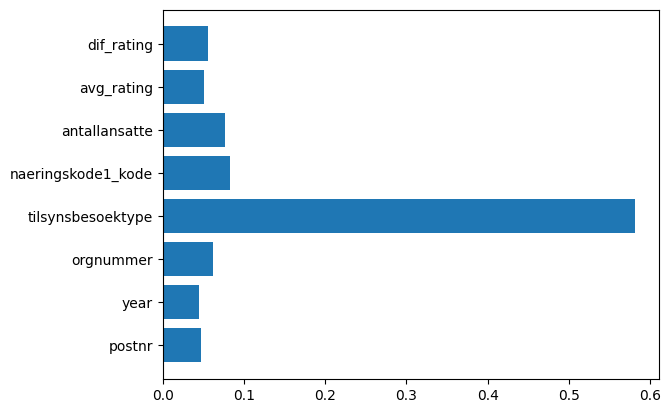

In [586]:
plt.barh(['postnr', 'year', 'orgnummer', 'tilsynsbesoektype', 'naeringskode1_kode', 'antallansatte', 'avg_rating', 'dif_rating'], regressor.feature_importances_)
plt.show()

# Scoring xg

In [587]:
# Train xg
r2_train_xg = regressor.score(X_train, y_train)
print(f'Train R2 XG : {r2_train_xg}') # 6f 0.3071 / m.år 0.4545

y_pred_train_xg = regressor.predict(X_train)
mse_train_xg = mean_squared_error(y_train, y_pred_train_xg)
print(f'Train MSE XG : {np.sqrt(mse_train_xg)}') # 6f 0.7480 / m.år 0.6641

mae_train_xg = mean_absolute_error(y_train, y_pred_train_xg)
print(f'Train MAE XG : {mae_train_xg}') # 6f 0.5854 / m.år 0.5156

# Test xg
r2_test_xg = regressor.score(X_test, y_test)
print(f'Test R2 XG : {r2_test_xg}') # 6f 0.1754 / m.år 0.2766

y_pred_test_xg = regressor.predict(X_test)
mse_test_xg = mean_squared_error(y_test, y_pred_test_xg)
print(f'Test MSE XG : {np.sqrt(mse_test_xg)}') # 6f 0.8305 / m.år 0.7755

mae_test_xg = mean_absolute_error(y_test, y_pred_test_xg)
print(f'Train MAE XG : {mae_test_xg}') # 6f 0.6631 / m.år 0.6029

Train R2 XG : 0.3668804950652069
Train MSE XG : 0.7340870844061301
Train MAE XG : 0.5879490196488018
Test R2 XG : 0.14634714670520244
Test MSE XG : 0.780632591117538
Train MAE XG : 0.5875221464792255


# Linear Regression Model

In [588]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_test, y_test)

## TRAIN

r2_train = lin_reg_model.score(X_train, y_train)
y_train_pred_linreg = lin_reg_model.predict(X_train)
mae_train = mean_absolute_error(y_train, y_train_pred_linreg)
mse_train = mean_squared_error(y_train, y_train_pred_linreg)
print(f'Train R2 : {r2_train}') # 0.1616 / 6f 0.17036 / m.år 0.1595
print(f'Train MAE : {mae_train}') # 0.6758 / 6f 0.6559 / m.år 0.6557
print(f'Train MSE : {np.sqrt(mse_train)}') # 0.8256 / 6f 0.8185 / m.år 0.8244

## TEST

r2_test = lin_reg_model.score(X_test, y_test)
y_test_pred_linreg = lin_reg_model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred_linreg)
mse_test = mean_squared_error(y_test, y_test_pred_linreg)
print(f'Test R2 : {r2_test}') # 0.1802 / 6f 0.1664 / m.år 0.2152
print(f'Test MAE : {mae_test}') # 0.6662 / 6f 0.6802 / m.år 0.6399
print(f'Test MSE : {np.sqrt(mse_test)}') # 0.8164 / 6f 0.8351 / m.år 0.8077

Train R2 : -0.7417422165117709
Train MAE : 0.9668683783960124
Train MSE : 1.2175776728197942
Test R2 : 0.1936395384606776
Test MAE : 0.5748972856882084
Test MSE : 0.7587009767914954


# Logistic Regression Model

Train accuracy : 0.5265392781316348
Train Precision : 0.0
Train Recall : 0.0


C:\Users\STM\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


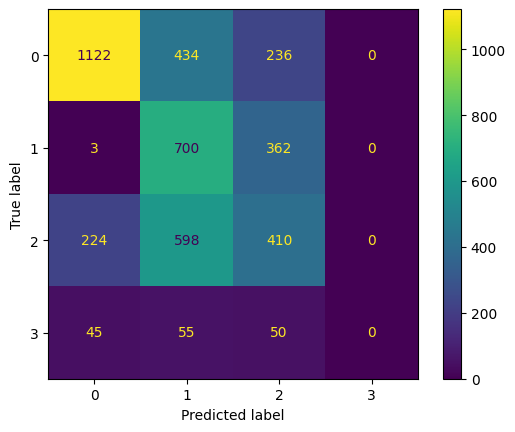

In [589]:
# y_train = y_train.reshape(-1)
log_reg_model = LogisticRegression(max_iter = 1000)
log_reg_model.fit(X_train, y_train)

y_pred_cm = log_reg_model.predict(X_train)
#y_train_pred_prod = log_reg_model.predict_proba(X_train)
#y_train_pred_prod_1 = y_train_pred_prod[:,1]
#y_train_pred = y_train_pred_prod_1 > 0.1

train_acc = accuracy_score(y_train, y_pred_cm)
print(f'Train accuracy : {train_acc}')

cm_train = confusion_matrix(y_train, y_pred_cm)

tn_train = cm_train[0,0]
fp_train = cm_train[1,1]
fn_train = cm_train[2,2]
tp_train = cm_train[3,3]

precision_train = tp_train/(tp_train+fp_train)
recall_train = tp_train/(tp_train+fn_train)
print(f'Train Precision : {precision_train}')
print(f'Train Recall : {recall_train}')

ConfusionMatrixDisplay(cm_train).plot()
plt.show()

# KNeighbors Regressor Model

In [590]:
model_knn = KNeighborsRegressor(n_neighbors=15)
model_knn.fit(X_train, y_train)

# KNN score
# Train
R2_train_knn = model_knn.score(X_train, y_train)
y_pred_train_knn = model_knn.predict(X_train)
mae_train_knn = mean_absolute_error(y_train, y_pred_train_knn)
mse_train_knn = mean_squared_error(y_train, y_pred_train_knn)
print(f'Knn Train Score:')
print(f'R2_train : {R2_train_knn}') # 0.3681
print(f'MAE train : {mae_train_knn}') # 0.5506
print(f'MSE train : {np.sqrt(mse_train_knn)}') # 0.7171

# Test
R2_test_knn = model_knn.score(X_test, y_test)
y_test_pred_knn = model_knn.predict(X_test)
mae_test_knn = mean_absolute_error(y_test, y_test_pred_knn)
mse_test_knn = mean_squared_error(y_test, y_test_pred_knn)
print(f'Knn Test Score:')
print(f'R2_test : {R2_test_knn}') # 0.1192
print(f'MAE test : {mae_test_knn}') # 0.6579
print(f'MSEtest : {np.sqrt(mse_test_knn)}') # 0.8453

Knn Train Score:
R2_train : 0.27395495489369526
MAE train : 0.6334827396398521
MSE train : 0.7861157895957684
Knn Test Score:
R2_test : 0.12307808361020911
MAE test : 0.6164377861007074
MSEtest : 0.791200390535215
